<a href="https://colab.research.google.com/github/luc-leonard/taming-transformers/blob/master/DALL_E_Mini_Inferencing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Inferencing [DALL-E Mini](https://github.com/borisdayma/dalle-mini)

### Colab by mega b#6696 | Originally from [here](https://github.com/borisdayma/dalle-mini/tree/main/demo)

### Heavily recommended to use a GPU runtime. Though, if needed, CPU works as well.

In [1]:
#@title # **Setup** run this once.

from IPython.display import clear_output

!pip install flax transformers
!git clone https://github.com/patil-suraj/vqgan-jax.git
!nvidia-smi

!pip install wandb

clear_output()

import random

import jax
import flax.linen as nn
from flax.training.common_utils import shard
from flax.jax_utils import replicate, unreplicate

from transformers.models.bart.modeling_flax_bart import *
from transformers import BartTokenizer, FlaxBartForConditionalGeneration

import io

import requests
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision.transforms as T
import torchvision.transforms.functional as TF
from torchvision.transforms import InterpolationMode

jax.devices()

%cd /content/vqgan-jax

!pip install -e .

clear_output()

from vqgan_jax.modeling_flax_vqgan import VQModel
%cd /content/

from IPython.display import HTML, display
import time

def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 50%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

# TODO: set those args in a config file
OUTPUT_VOCAB_SIZE = 16384 + 1  # encoded image token space + 1 for bos
OUTPUT_LENGTH = 256 + 1  # number of encoded tokens + 1 for bos
BOS_TOKEN_ID = 16384
BASE_MODEL = 'facebook/bart-large-cnn'

class CustomFlaxBartModule(FlaxBartModule):
    def setup(self):
        # we keep shared to easily load pre-trained weights
        self.shared = nn.Embed(
            self.config.vocab_size,
            self.config.d_model,
            embedding_init=jax.nn.initializers.normal(self.config.init_std, self.dtype),
            dtype=self.dtype,
        )
        # a separate embedding is used for the decoder
        self.decoder_embed = nn.Embed(
            OUTPUT_VOCAB_SIZE,
            self.config.d_model,
            embedding_init=jax.nn.initializers.normal(self.config.init_std, self.dtype),
            dtype=self.dtype,
        )
        self.encoder = FlaxBartEncoder(self.config, dtype=self.dtype, embed_tokens=self.shared)

        # the decoder has a different config
        decoder_config = BartConfig(self.config.to_dict())
        decoder_config.max_position_embeddings = OUTPUT_LENGTH
        decoder_config.vocab_size = OUTPUT_VOCAB_SIZE
        self.decoder = FlaxBartDecoder(decoder_config, dtype=self.dtype, embed_tokens=self.decoder_embed)

class CustomFlaxBartForConditionalGenerationModule(FlaxBartForConditionalGenerationModule):
    def setup(self):
        self.model = CustomFlaxBartModule(config=self.config, dtype=self.dtype)
        self.lm_head = nn.Dense(
            OUTPUT_VOCAB_SIZE,
            use_bias=False,
            dtype=self.dtype,
            kernel_init=jax.nn.initializers.normal(self.config.init_std, self.dtype),
        )
        self.final_logits_bias = self.param("final_logits_bias", self.bias_init, (1, OUTPUT_VOCAB_SIZE))

class CustomFlaxBartForConditionalGeneration(FlaxBartForConditionalGeneration):
    module_class = CustomFlaxBartForConditionalGenerationModule

# create our model
tokenizer = BartTokenizer.from_pretrained(BASE_MODEL)
model = CustomFlaxBartForConditionalGeneration.from_pretrained("flax-community/dalle-mini")
model.config.force_bos_token_to_be_generated = False
model.config.forced_bos_token_id = None
model.config.forced_eos_token_id = None

# we verify that the shape has not been modified
model.params['final_logits_bias'].shape

vqgan = VQModel.from_pretrained("flax-community/vqgan_f16_16384")

def custom_to_pil(x):
    x = np.clip(x, 0., 1.)
    x = (255*x).astype(np.uint8)
    x = Image.fromarray(x)
    if not x.mode == "RGB":
        x = x.convert("RGB")
    return x

def generate(input, rng, params):
  return model.generate(
      **input,
      max_length=257,
      num_beams=1,
      do_sample=True,
      prng_key=rng,
      eos_token_id=50000,
      pad_token_id=50000,
      params=params
  )

def get_images(indices, params):
    return vqgan.decode_code(indices, params=params)


def plot_images(images):
    fig = plt.figure(figsize=(40, 20))
    columns = 4
    rows = 2
    plt.subplots_adjust(hspace=0, wspace=0)

    for i in range(1, columns*rows +1):
        fig.add_subplot(rows, columns, i)
        plt.imshow(images[i-1])
    plt.gca().axes.get_yaxis().set_visible(False)
    plt.show()
    
def stack_reconstructions(images):
    w, h = images[0].size[0], images[0].size[1]
    img = Image.new("RGB", (len(images)*w, h))
    for i, img_ in enumerate(images):
        img.paste(img_, (i*w,0))
    return img

p_generate = jax.pmap(generate, "batch")
p_get_images = jax.pmap(get_images, "batch")

bart_params = replicate(model.params)
vqgan_params = replicate(vqgan.params)

clear_output()

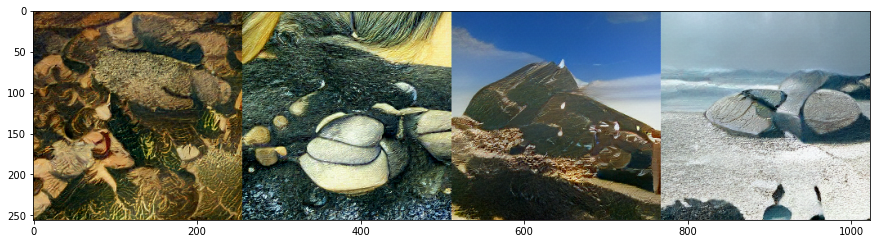

In [7]:
#@title # **Inferencing** try it out!

input = "A bunch of rocks" #@param {type:"string"}

num_images = 4 #@param {type:"integer"}

prompts = [input]

prompt = [prompts[0]] * jax.device_count()
inputs = tokenizer(prompt, return_tensors='jax', padding="max_length", truncation=True, max_length=128).data
inputs = shard(inputs)

out = display(progress(0, 4), display_id=True)

imges = []

for i in range(num_images):
    key = random.randint(0, 1e7)
    rng = jax.random.PRNGKey(key)
    rngs = jax.random.split(rng, jax.local_device_count())
    indices = p_generate(inputs, rngs, bart_params).sequences
    indices = indices[:, :, 1:]

    images = p_get_images(indices, vqgan_params)

    images = np.squeeze(np.asarray(images), 1)

    imges += [custom_to_pil(image) for image in images]

    out.update(progress(i, num_images - 1))

plt.figure(figsize=(15, 5))

clear_output()

plt.imshow(stack_reconstructions(imges))

## **CLIP Scoring** Optional

In [4]:
#@title # **Setup CLIP scoring** run this once.

from transformers import CLIPProcessor, FlaxCLIPModel

clip = FlaxCLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

def hallucinate(prompt, num_images=64):
    prompt = [prompt] * jax.device_count()
    inputs = tokenizer(prompt, return_tensors='jax', padding="max_length", truncation=True, max_length=128).data
    inputs = shard(inputs)
    out = display(progress(0, num_images), display_id=True)
    all_images = []
    for i in range(num_images // jax.device_count()):
        key = random.randint(0, 1e7)
        rng = jax.random.PRNGKey(key)
        rngs = jax.random.split(rng, jax.local_device_count())
        indices = p_generate(inputs, rngs, bart_params).sequences
        indices = indices[:, :, 1:]

        images = p_get_images(indices, vqgan_params)
        images = np.squeeze(np.asarray(images), 1)
        for image in images:
            all_images.append(custom_to_pil(image))
            out.update(progress(len(all_images), num_images))


    return all_images

def clip_top_k(prompt, images, k=8):
    inputs = processor(text=prompt, images=images, return_tensors="np", padding=True)
    outputs = clip(**inputs)
    logits = outputs.logits_per_text
    scores = np.array(logits[0]).argsort()[-k:][::-1]
    return [images[score] for score in scores]

clear_output()

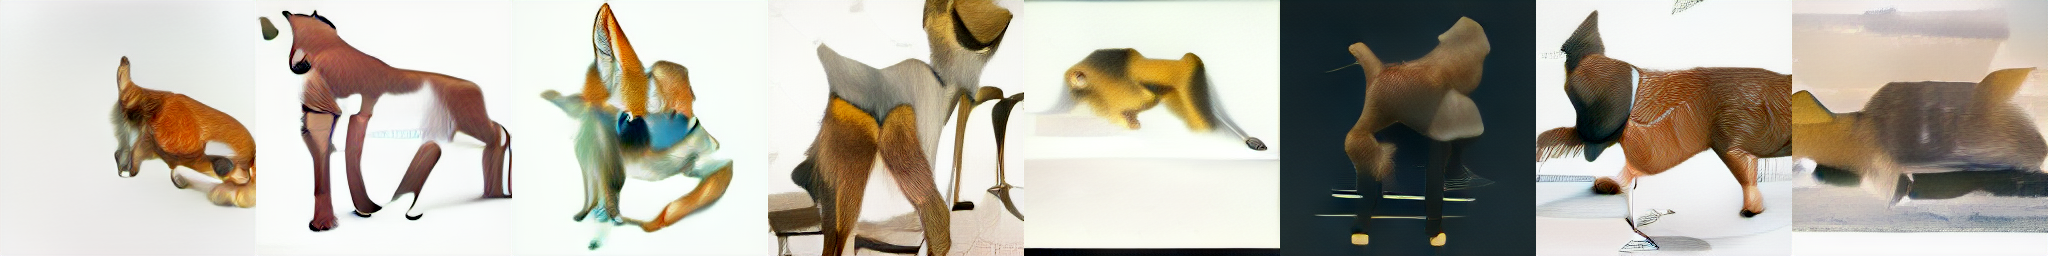

In [9]:
#@title # **Inferencing with CLIP scoring**
#@markdown ### The best images will appear first.

#@markdown ---

prompt = "A 3d render of a fox" #@param {type:"string"}

#@markdown #### Amount of images to generate. Usually more the better.

total_images =  32#@param {type:"integer"}

#@markdown #### Highest rated images from CLIP to show after generating finished.

show_top_results = 8 #@param {type:"integer"}

print("Generating images")
images = hallucinate(prompt, total_images)
print("Ranking images...")
selected = clip_top_k(prompt, images, k=show_top_results)
clear_output()
stack_reconstructions(selected)